# 2b: Practical verification of Ordinary Least Squares properties using simulations in Julia

In [30]:
using DataFrames, GLM, Markdown, Plots, Plots.PlotMeasures, Random, Statistics

In [31]:
Random.seed!(42)

TaskLocalRNG()

## a. Synthetic data simulation according to linear regression data generating process

Define a data generating process to generate synthetic data for sales of water bottles.

In [32]:
function dgp(N::Int=100, # number of observations
    β₀::Float64=30.0, # intercept, or bias of LR
    β₁::Float64=-1.0, # 1st coefficient measuring impact of price on sales volume
    β₂::Float64=0.25 # 2nd coefficient
)
    temperature = 10 .+ 5 * randn(N)
    rainfall = max.(0, temperature .- 10 + 5 * randn(N)) # rainfall depends positively on temperature
    price = 14 .+ temperature / 10 + randn(N) / 2 # price depends positively on temperature
    demand = β₀ .+ β₁ * price + β₂ * temperature + randn(N)
    # (; a, b, c) creates a named tuple
    return DataFrame(; price, temperature, rainfall, demand)
end

dataset = dgp()

Row,price,temperature,rainfall,demand
,Float64,Float64,Float64,Float64
1,15.0319,8.18321,2.82812,19.2189
2,15.3358,11.2587,0.0,17.6627
3,15.113,8.42506,0.0,18.0226
4,15.4272,8.44374,0.0,16.1177
5,15.0288,14.0815,0.0,18.1896
6,15.2924,12.3837,3.42786,19.4884
7,13.8797,5.70222,0.0,16.6978
8,14.0164,2.65356,0.0,16.7662
9,14.157,-0.571674,0.0,15.947


## b. Visualise simulated data

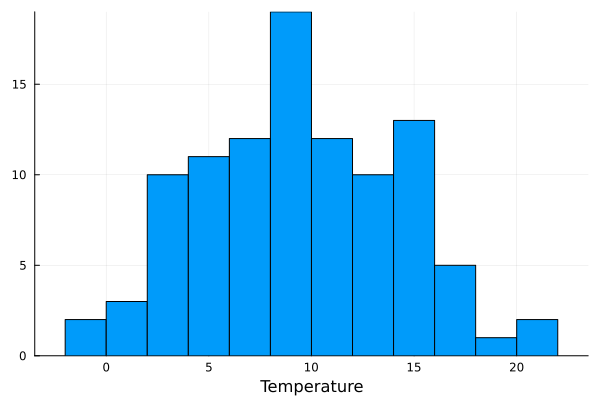

In [33]:
histogram(dataset.temperature, xlab="Temperature", bins=15, legend=false)

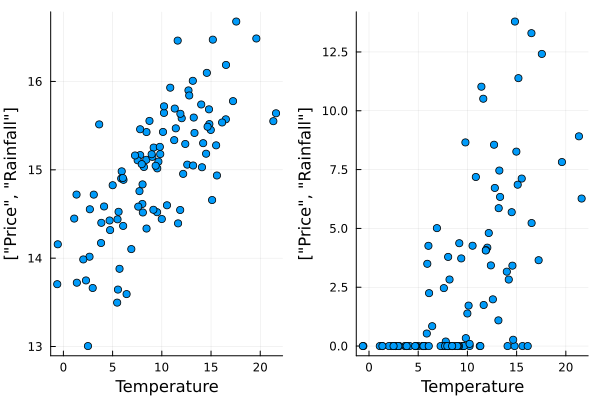

In [34]:
scatter(dataset.temperature, Matrix(dataset[!, [:price, :rainfall]]), layout=(1, 2), xlabel="Temperature", ylabel=["Price", "Rainfall"], legend=false)

In [35]:
# Peason correlations
cor(dataset.temperature, Matrix(dataset[!, [:price, :rainfall]]))

1×2 transpose(::Vector{Float64}) with eltype Float64:
 0.733104  0.617714

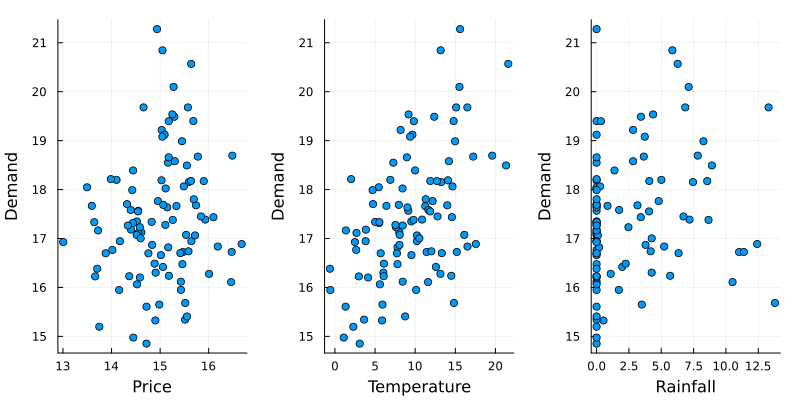

In [36]:
scatter(Matrix(dataset[!, [:price, :temperature, :rainfall]]),
    dataset.demand, layout=(1, 3), size=(800, 400), margins=3.0mm, ylabel="Demand", xlabel=["Price" "Temperature" "Rainfall"], legend=false)

In [37]:
round.(cor(Matrix(dataset[!, 1:3]), dataset.demand), digits=4)

3×1 Matrix{Float64}:
 0.1476
 0.5082
 0.2021

## c. Linear regression estimation using Ordinary Least Squares (OLS)
Esitmate linear regression using own matrix algebra implementation:

In [38]:
least_squares(x::Matrix, y::Vector) = [ones(size(y)) x] \ y
βs = least_squares(Matrix(dataset[!, 1:3]), dataset.demand)

# [ones(size(dataset.demand)) Matrix(dataset[!, 1:3])] \ dataset.demand

4-element Vector{Float64}:
 27.657906356668516
 -0.8304386077297659
  0.2462767612755362
 -0.039581359538538995

Or use GLM package:

In [39]:
specification = @formula(demand ~ price + temperature + rainfall)

FormulaTerm
Response:
  demand(unknown)
Predictors:
  price(unknown)
  temperature(unknown)
  rainfall(unknown)

Esitmate model based on dataset:

In [40]:
fitted_OLS = lm(specification, dataset)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

demand ~ 1 + price + temperature + rainfall

Coefficients:
───────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  27.6579      3.03319     9.12    <1e-13  21.6371    33.6787
price        -0.830439    0.21583    -3.85    0.0002  -1.25886   -0.402019
temperature   0.246277    0.0344846   7.14    <1e-09   0.177825   0.314728
rainfall     -0.0395814   0.0375933  -1.05    0.2950  -0.114204   0.0350408
───────────────────────────────────────────────────────────────────────────

In [41]:
R² = r2(fitted_OLS)

0.37489244194418714

## d. Demonstration of unbiasedness OLS property using Monte Carlo (MC) simulations
Each data generating process (`dgp()`) creates 100 samples. Run this DGP 1e5 times and compare the MC-of-MC (1e7) results with the MC (1e2) results to see how well the OLS method approximates the true values, which are revealed by Monte-Carloing the data generating process and the OLS fitting.

Initialise empty arrays to be populated by MC simluation's results.

In [42]:
estimation_columns = ["β₀", "β₁", "β₂", "β₃", "β₃ p-value", "R²"]
estimation_results = DataFrame([column_name => Float64[] for column_name in estimation_columns])

Row,β₀,β₁,β₂,β₃,β₃ p-value,R²
,Float64,Float64,Float64,Float64,Float64,Float64


In [43]:
# Run MC simulations
N = 100_000
for i in 1:N
    dataset = dgp()
    fitted_OLS = lm(specification, dataset)
    push!(estimation_results,
        [coef(fitted_OLS)[1:4] # Newlines are important here!
            DataFrame(coeftable(fitted_OLS))[4, 5]
            r2(fitted_OLS)])
end
estimation_results

Row,β₀,β₁,β₂,β₃,β₃ p-value,R²
,Float64,Float64,Float64,Float64,Float64,Float64
1,25.7668,-0.713509,0.235573,-0.00418152,0.907565,0.393549
2,31.4056,-1.09244,0.228595,0.023775,0.432246,0.480995
3,28.3278,-0.861092,0.227927,-0.00520849,0.894821,0.317543
4,29.51,-0.985326,0.264324,0.0344252,0.246999,0.551293
5,32.5881,-1.19428,0.278465,0.0168986,0.583234,0.556306
6,29.6392,-0.968159,0.238593,0.00197368,0.947674,0.491655
7,26.8514,-0.781525,0.217882,0.0657133,0.0808013,0.459951
8,27.5844,-0.83639,0.253112,-0.0107668,0.772855,0.444599
9,25.8248,-0.718366,0.230792,0.0122463,0.694697,0.408437


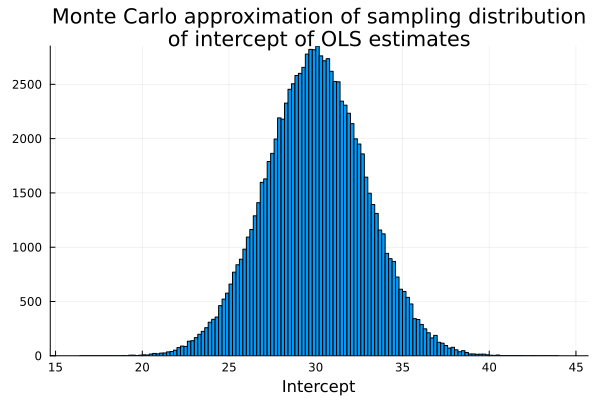

In [44]:
histogram(estimation_results.β₀, title="Monte Carlo approximation of sampling distribution
of intercept of OLS estimates", xlabel="Intercept", legend=false)

In [45]:
intercept_est = round(DataFrame(coeftable(fitted_OLS))[1, 2], sigdigits=3)
intercept_mc = round(mean(estimation_results.β₀), sigdigits=3)
std_est = round(DataFrame(coeftable(fitted_OLS))[1, 3], sigdigits=3)
std_mc = round(std(estimation_results.β₀), sigdigits=3)
conf_est = string(round.(Vector(DataFrame(coeftable(fitted_OLS))[1, 6:7]), sigdigits=3))
conf_mc = string(round.(quantile(estimation_results.β₀, [0.025, 0.975]), sigdigits=3));

In [46]:
display(md"""
The intercept (β₀) estimated by Ordinary Least Squares (OLS) at the value of 
**$(intercept_est)**,
can be considered as a random variable derived from so called sampling distribution that 
we approximated (see histogram) through Monte Carlo simulations with:
1. a mean of **$intercept_mc**
    equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation (called standard error of the estimate) of **$std_mc** 
    (estimated by OLS to be 
    **$std_est**)
    which is the minimal possible standard error (efficiency property of an estimator)
3. 95%-Confidence Interval of
    **$conf_mc**
    (estimated by OLS to be **$conf_est**).

Let us have a look at complete table for OLS estimates:
<div>
$(PrettyTables.pretty_table(String, DataFrame(coeftable(fitted_OLS)),tf=PrettyTables.tf_html_dark))
</div>
""")

The intercept (β₀) estimated by Ordinary Least Squares (OLS) at the value of  **28.0**, can be considered as a random variable derived from so called sampling distribution that  we approximated (see histogram) through Monte Carlo simulations with:

1. a mean of **30.0**  equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation (called standard error of the estimate) of **2.89**   (estimated by OLS to be   **2.78**)  which is the minimal possible standard error (efficiency property of an estimator)
3. 95%-Confidence Interval of  **[24.3, 35.6]**  (estimated by OLS to be **[22.5, 33.6]**).

Let us have a look at complete table for OLS estimates: <div> <table>
  <thead>
    <tr class = "header">
      <th style = "text-align: right;">Name</th>
      <th style = "text-align: right;">Coef.</th>
      <th style = "text-align: right;">Std. Error</th>
      <th style = "text-align: right;">t</th>
      <th style = "text-align: right;">Pr(&gt;|t|)</th>
      <th style = "text-align: right;">Lower 95%</th>
      <th style = "text-align: right;">Upper 95%</th>
    </tr>
    <tr class = "subheader headerLastRow">
      <th style = "text-align: right;">String</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style = "text-align: right;">(Intercept)</td>
      <td style = "text-align: right;">28.0334</td>
      <td style = "text-align: right;">2.7798</td>
      <td style = "text-align: right;">10.0847</td>
      <td style = "text-align: right;">9.78427e-17</td>
      <td style = "text-align: right;">22.5156</td>
      <td style = "text-align: right;">33.5513</td>
    </tr>
    <tr>
      <td style = "text-align: right;">price</td>
      <td style = "text-align: right;">-0.879424</td>
      <td style = "text-align: right;">0.197992</td>
      <td style = "text-align: right;">-4.4417</td>
      <td style = "text-align: right;">2.38929e-5</td>
      <td style = "text-align: right;">-1.27244</td>
      <td style = "text-align: right;">-0.486412</td>
    </tr>
    <tr>
      <td style = "text-align: right;">temperature</td>
      <td style = "text-align: right;">0.267729</td>
      <td style = "text-align: right;">0.0347243</td>
      <td style = "text-align: right;">7.71015</td>
      <td style = "text-align: right;">1.16052e-11</td>
      <td style = "text-align: right;">0.198802</td>
      <td style = "text-align: right;">0.336656</td>
    </tr>
    <tr>
      <td style = "text-align: right;">rainfall</td>
      <td style = "text-align: right;">-0.0279852</td>
      <td style = "text-align: right;">0.0282196</td>
      <td style = "text-align: right;">-0.991694</td>
      <td style = "text-align: right;">0.32384</td>
      <td style = "text-align: right;">-0.0840008</td>
      <td style = "text-align: right;">0.0280303</td>
    </tr>
  </tbody>
</table>
 </div>


The single OLS estimated the intercept to be 28.0, but the MC of multiple OLS's showed that the intercept is 30.0.

Perform the same analysis for price, temperature and rainfall:

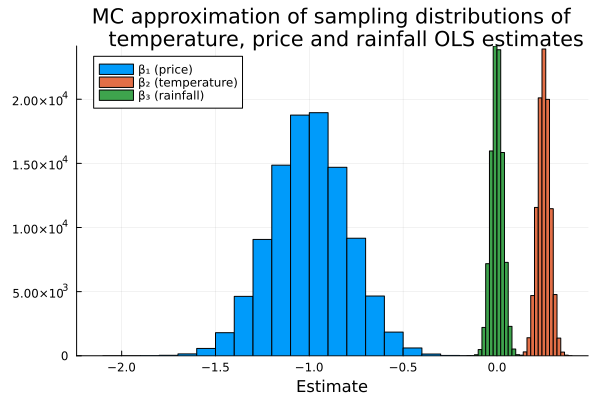

In [47]:
histogram(Matrix(estimation_results[!, 2:4]),
    bins=25, xlabel="Estimate", labels=["β₁ (price)" "β₂ (temperature)" "β₃ (rainfall)"],
    title="MC approximation of sampling distributions of
    temperature, price and rainfall OLS estimates")

In [48]:
price_est = round(DataFrame(coeftable(fitted_OLS))[2, 2], sigdigits=3)
price_mc = round(mean(estimation_results.β₁), sigdigits=2)
std_price_est = round(DataFrame(coeftable(fitted_OLS))[2, 3], sigdigits=3)
std_price_mc = round(std(estimation_results.β₁), sigdigits=3)
conf_price_est = string(round.(Array(DataFrame(coeftable(fitted_OLS))[2, 6:7]), sigdigits=3))
conf_price_mc = string(round.(quantile(estimation_results.β₁, [0.025, 0.975]), sigdigits=3))
display(md"""
The **price** impact coefficient (β₁) estimated by Ordinary Least Squares (OLS) at the value of **$(price_est)** can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:
1. a mean of **$(price_mc)** equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation of **$(std_price_mc)** being estimated by OLS to be **$(std_price_est)** - the minimal possible standard error (efficiency property of an estimator),
3. 95%-Confidence Interval of **$(conf_price_mc)** being estimated by OLS to be **$(conf_price_est)**.
""")

The **price** impact coefficient (β₁) estimated by Ordinary Least Squares (OLS) at the value of **-0.879** can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:

1. a mean of **-1.0** equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation of **0.206** being estimated by OLS to be **0.198** - the minimal possible standard error (efficiency property of an estimator),
3. 95%-Confidence Interval of **[-1.4, -0.595]** being estimated by OLS to be **[-1.27, -0.486]**.


In [49]:
temperature_est = round(DataFrame(coeftable(fitted_OLS))[3, 2], sigdigits=3)
temperature_mc = round(mean(estimation_results.β₂), sigdigits=3)
std_temperature_est = round(DataFrame(coeftable(fitted_OLS))[3, 3], sigdigits=3)
std_temperature_mc = round(std(estimation_results.β₂), sigdigits=3)
conf_temperature_est = string(round.(Array(DataFrame(coeftable(fitted_OLS))[3, 6:7]), sigdigits=3))
conf_temperature_mc = string(round.(quantile(estimation_results.β₂, [0.025, 0.975]), sigdigits=3))
display(md"""
The **temperature** impact coefficient (β₂) estimated by Ordinary Least Squares (OLS) at the value of **$temperature_est** can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:
1. a mean of **$temperature_mc** equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation of **$std_temperature_mc** being estimated by OLS to be **$std_temperature_est** - the minimal possible standard error (efficiency property of an estimator),
3. 95%-Confidence Interval of **$conf_temperature_mc** being estimated by OLS to be **$(conf_temperature_est)**.
""")

The **temperature** impact coefficient (β₂) estimated by Ordinary Least Squares (OLS) at the value of **0.268** can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:

1. a mean of **0.25** equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation of **0.033** being estimated by OLS to be **0.0347** - the minimal possible standard error (efficiency property of an estimator),
3. 95%-Confidence Interval of **[0.185, 0.315]** being estimated by OLS to be **[0.199, 0.337]**.


In [50]:
rainfall_est = round(DataFrame(coeftable(fitted_OLS))[4, 2], sigdigits=3)
rainfall_mc = round(mean(estimation_results.β₃), digits=3)
std_rainfall_est = round(DataFrame(coeftable(fitted_OLS))[4, 3], sigdigits=3)
std_rainfall_mc = round(std(estimation_results.β₃), sigdigits=3)
conf_rainfall_est = string(round.(Array(DataFrame(coeftable(fitted_OLS))[4, 6:7]), sigdigits=3))
conf_rainfall_mc = string(round.(quantile(estimation_results.β₃, [0.025, 0.975]), sigdigits=3))
display(md"""
The **rainfall** impact coefficient (β₃) estimated by Ordinary Least Squares (OLS) at the value of **$rainfall_est** can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:
1. a mean of **$rainfall_mc** equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation of **$std_rainfall_mc** being estimated by OLS to be **$std_rainfall_est** - the minimal possible standard error (efficiency property of an estimator),
3. 95%-Confidence Interval of **$conf_rainfall_mc** being estimated by OLS to be **$(conf_rainfall_est)**.
""")

The **rainfall** impact coefficient (β₃) estimated by Ordinary Least Squares (OLS) at the value of **-0.028** can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:

1. a mean of **0.0** equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation of **0.0315** being estimated by OLS to be **0.0282** - the minimal possible standard error (efficiency property of an estimator),
3. 95%-Confidence Interval of **[-0.0615, 0.0621]** being estimated by OLS to be **[-0.084, 0.028]**.


Sampling distribution of rainfall significance test p-values:

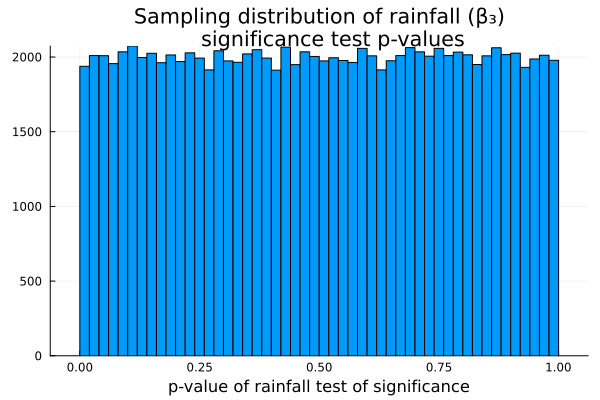

In [52]:
histogram(estimation_results."β₃ p-value",
    xlabel="p-value of rainfall test of significance",
    title="Sampling distribution of rainfall (β₃)
    significance test p-values",
    legend=false)

In [53]:
display(md"""Given the null hypothesis of no impact of rainfall being true, the sampling distribution of p-values will be uniform on [0, 1] - see a histogram above.

As a result, using the significance level of α = 5% will result in rejecting the true null hypothesis (so called type I error or false positive) of no rainflall impact on demand as often as 
    **$(round(mean(estimation_results."β₃ p-value" .< 0.05), sigdigits = 2) * 100)%** of times."""
)

Given the null hypothesis of no impact of rainfall being true, the sampling distribution of p-values will be uniform on [0, 1] - see a histogram above.

As a result, using the significance level of α = 5% will result in rejecting the true null hypothesis (so called type I error or false positive) of no rainflall impact on demand as often as      **4.9%** of times.


Key takeaways:
- It's unavoidable to make a type I error (false positive), so be aware of it, whenever you claim the impact of X, e.g. rainfall,  on Y, e.g. demand,
- You're controlling the probability of type I error (false positive) by setting up the significance level, e.g. α ∈ [1%, 5%, 10%],,
- However, there's no free lunch, but a trade-off, since the lower the probability of false positive, e.g. α ∈ [1%, 5%, 10%], the higher the probability of so called type II error (false negative), which is failing to reject a false null hypothesis. This type of error is higher the smaller data is, so you might want to choose higher α e.g. 5%, 10% for smaller data and smaller  α e.g. 1% or 5% for bigger data.

In [54]:
println("The coefficient of determination (R²) estimated by Ordinary Least Squares (OLS) at the value of ",
    round(r2(fitted_OLS), sigdigits=3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:\n",
    "(1) a mean of ",
    round(mean(estimation_results.R²), sigdigits=3),
    "\n(2) a standard deviation of ",
    round(std(estimation_results.R²), sigdigits=3),
    "\n(3) 95%-Confidence Interval of ",
    round.(quantile(estimation_results.R², [0.025, 0.975]),
        sigdigits=3),
    ".")

The coefficient of determination (R²) estimated by Ordinary Least Squares (OLS) at the value of 0.456 can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:
(1) a mean of 0.46
(2) a standard deviation of 0.0731
(3) 95%-Confidence Interval of [0.312, 0.597].


## e. Coefficient biasedness due to correlated omitted variable
Define a simple but wrong specification omitted both temperature and rainfall:

In [56]:
wrong_specification = @formula(demand ~ price)
wrong_spec_model = lm(wrong_specification, dataset)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

demand ~ 1 + price

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  12.6161      2.82351   4.47    <1e-04   7.01293    18.2193
price         0.322858    0.186676  1.73    0.0869  -0.0475941   0.693311
─────────────────────────────────────────────────────────────────────────

Create dataframe for biased estimates and run MC simulations:

In [57]:
biased_estimate_names = ["β₁", "β₁ p-value"]
biased_estimates = DataFrame([column_name => Float64[] for column_name in biased_estimate_names])

Row,β₁,β₁ p-value
,Float64,Float64


In [58]:
for i in 1:N
    dataset = dgp()
    wrong_spec_model = lm(wrong_specification, dataset)
    push!(biased_estimates, [coef(wrong_spec_model)[2] DataFrame(coeftable(wrong_spec_model))[2, 5]])
end

Sampling coefficient of price coefficient in a wrongly-specified model:

In [59]:
biased_estimates

Row,β₁,β₁ p-value
,Float64,Float64
1,0.145275,0.38847
2,-0.0351836,0.838835
3,-0.197448,0.272823
4,0.423587,0.0140874
5,0.427178,0.0464155
6,0.278289,0.163223
7,0.235163,0.171556
8,0.178758,0.292639
9,0.315003,0.0743162


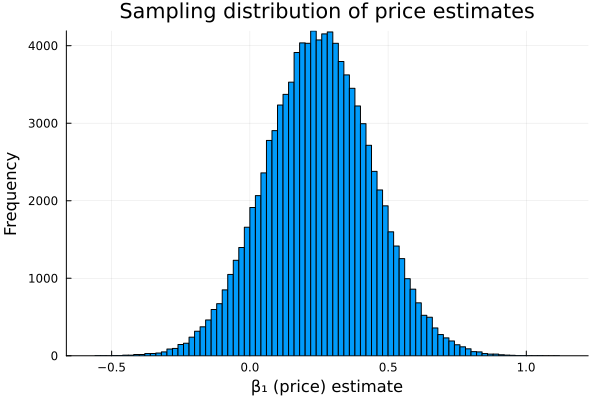

In [60]:
histogram(biased_estimates.β₁, xlabel="β₁ (price) estimate", ylabel="Frequency", title="Sampling distribution of price estimates", legend=false)

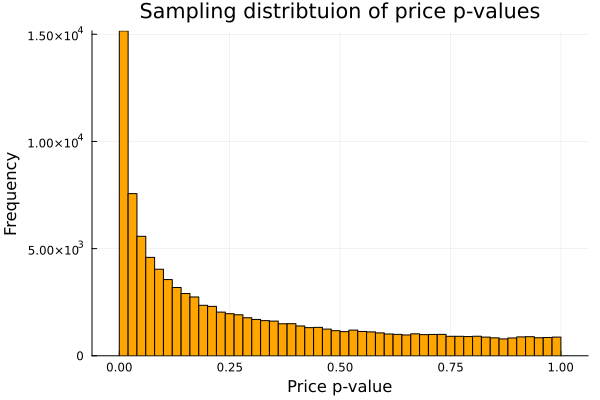

In [61]:
histogram(biased_estimates."β₁ p-value", xlabel="Price p-value", ylabel="Frequency", color="orange", title="Sampling distribtuion of price p-values", legend=false)

Bias is the difference between expected value of an estimate and the true value:

In [62]:
bias = mean(biased_estimates.β₁) - (-1)

1.250112253630883

In [63]:
println("OLS estimate of price coefficient is biased, i.e. systematically being wrong with an expected value of ",
    round(mean(biased_estimates.β₁), sigdigits=3),
    ".\nGiven a true price coefficient value of -1, the total bias is equal to (",
    round(mean(biased_estimates.β₁), sigdigits=3),
    " - (-1)) = ", round(bias, sigdigits=3))
println("This bias is due to the omitted variable, i.e. temperature impacting both price and demand, e.g. ommiting a rainfall doesn't result in a bias even though it is correlated with price but not impacting a demand.")
println("Since the temperature is impacting both demand and price, when ommited its postive impact on demand is overtaken by the price, which results in a biased price impact estimation.")


OLS estimate of price coefficient is biased, i.e. systematically being wrong with an expected value of 0.25.
Given a true price coefficient value of -1, the total bias is equal to (0.25 - (-1)) = 1.25
This bias is due to the omitted variable, i.e. temperature impacting both price and demand, e.g. ommiting a rainfall doesn't result in a bias even though it is correlated with price but not impacting a demand.
Since the temperature is impacting both demand and price, when ommited its postive impact on demand is overtaken by the price, which results in a biased price impact estimation.
